# **Graph Isomorphism Network**

In this project, we will explore a newer GNN architecure called Graph Isomorphism Networks (GIN). The paper used for this project can be found [here](https://arxiv.org/pdf/1810.00826.pdf).

Datasets used: [MUTAG](https://paperswithcode.com/dataset/mutag), [PROTEINS](https://paperswithcode.com/dataset/proteins), [NCTI1](https://paperswithcode.com/dataset/nci1).

## Import Libraries

In [9]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import to_networkx
from mpl_toolkits.mplot3d import Axes3D

## Helper Functions

### Define the GIN class

In [11]:
class GIN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_layers, num_classes):
        super(GIN, self).__init__()

        # First GINConv layer
        self.layers = nn.ModuleList()
        self.layers.append(GINConv(nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )))

        # Reamining GINConv layers
        for layer in range(num_layers - 1):
            self.layers.append(GINConv(nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU()
            )))

        # MLP for graph-level prediction
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x, edge_index, batch):
        # Apply layers
        for layer in self.layers:
            x = layer(x, edge_index)

        # Global readout
        x = global_add_pool(x, batch)
        # Classifier
        x = self.mlp(x)

        return x

### Initialize the model
#### Load the requested dataset and create the appropriate GIN model

In [17]:
def initialize_model(data_name, hidden, layers, verbose = False):

    # Load named dataset
    dataset = TUDataset(root='.', name=data_name)

    # Split dataset into training and testing
    train_dataset = dataset[:int(len(dataset) * 0.8)]
    test_dataset = dataset[int(len(dataset) * 0.8):]
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize hyperparamters
    num_features = dataset.num_features
    num_classes = dataset.num_classes
    hidden_dim = hidden
    num_layers = layers

    # Initialize GIN model
    model = GIN(num_features, hidden_dim, num_layers, num_classes)

    if verbose:
      # Print out important data set information
      print(f'Dataset: {dataset}')
      print('-------------------')
      print(f'Number of graphs: {len(dataset)}')
      print(f'Number of nodes: {dataset[0].x.shape[0]}')
      print(f'Number of features: {dataset.num_features}')
      print(f'Number of classes: {dataset.num_classes}')
      print('-------------------')
      print(f'Number of hidden dimensions: {hidden_dim}')
      print(f'Number of layers: {num_layers}')
      print('-------------------')

    return model, train_loader, test_loader, dataset

### Train the model

In [38]:
def train(model, loader, decay, verbose = False):

    # Initialize loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=decay)
    
    if verbose:
      print(f'Weight Decay: {decay}')
      print('-------------------')

    # Number of epochs
    num_epochs = 100
    # put model into training mde
    model.train()
    # Training loop
    for epoch in range(num_epochs):
        # Initialize nested loop variables
        total = 0
        correct = 0
        # Data loop
        for batch in loader:
            # Extract features
            x, edge_index, y = batch.x, batch.edge_index, batch.y
            # reset Gradient
            optimizer.zero_grad()
            # Forward pass through model
            output = model(x, edge_index, batch.batch)
            # calculation of loss and correctly predicted outputs
            loss = criterion(output, y)
            _, predicted = output.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
            # Compute gradients
            loss.backward()
            # Update params
            optimizer.step()
        
        # Calculate acuuracy
        accuracy = correct / total

        if verbose:
          # Print everyy 10 Epoch results
          if(epoch % 10 == 0):
              print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2%}'.format(
                  epoch, num_epochs, loss.item(), accuracy))
          if epoch == 99:
              print('Epoch [{}/{}], Loss: {:.4f}, Accuracy: {:.2%}'.format(
                epoch+1, num_epochs, loss.item(), accuracy))
        
        
    return model

### Test the model

In [14]:
def test(model, loader, verbose = False):
  # Evaluation
  # put model into evaluation mode
  model.eval()
  # Initialize variables
  criterion = nn.CrossEntropyLoss()
  loss = 0
  acc = 0
  # Turn off gradient computation to evaluatie
  with torch.no_grad():
      # Data loop
      for batch in loader:
          # Extract features
          x, edge_index, y = batch.x, batch.edge_index, batch.y
          # Forward pass through model
          output = model(x, edge_index, batch.batch)
          # calculation of loss and accuracy
          loss += criterion(output, y) / len(loader)
          acc += (((output.argmax(dim=1) == y).sum() / len(y)).item()) / len(loader)

  if verbose:
    # Print test results
    print(f'Test Loss: {loss:.2f} | Test Acc: {acc*100:.2f}%')

  return model, acc

## Models

#### MUTAG model

In [39]:
# Initialize Dataset and model
GIN1, GIN1_train, GIN1_test, GIN1_dataset = initialize_model('MUTAG', 64, 5, verbose = True)
# Train model
GIN1 = train(GIN1, GIN1_train, 0.01, verbose = True)
# Test Model
GIN1, acc = test(GIN1, GIN1_test, verbose = True)

Dataset: MUTAG(188)
-------------------
Number of graphs: 188
Number of nodes: 17
Number of features: 7
Number of classes: 2
-------------------
Number of hidden dimensions: 64
Number of layers: 5
-------------------
Weight Decay: 0.01
-------------------
Epoch [0/100], Loss: 0.6005, Accuracy: 67.33%
Epoch [10/100], Loss: 0.1176, Accuracy: 92.67%
Epoch [20/100], Loss: 0.1523, Accuracy: 96.00%
Epoch [30/100], Loss: 0.0957, Accuracy: 94.00%
Epoch [40/100], Loss: 0.1533, Accuracy: 97.33%
Epoch [50/100], Loss: 0.0347, Accuracy: 96.00%
Epoch [60/100], Loss: 0.5250, Accuracy: 91.33%
Epoch [70/100], Loss: 0.2752, Accuracy: 97.33%
Epoch [80/100], Loss: 0.0288, Accuracy: 99.33%
Epoch [90/100], Loss: 0.3658, Accuracy: 98.00%
Epoch [100/100], Loss: 1.2586, Accuracy: 95.33%
Test Loss: 1.01 | Test Acc: 78.95%


#### PROTEINS model

In [21]:
# Initialize Dataset and model
GIN2, GIN2_train, GIN2_test, GIN2_dataset = initialize_model('PROTEINS', 64, 5, verbose = True)
# Train model
GIN2 = train(GIN2, GIN2_train, 0.01, verbose = True)
# Test Model
GIN2, GIN2_acc = test(GIN2, GIN2_test, verbose = True)

Extracting ./PROTEINS/PROTEINS.zip
Processing...
Done!


Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 42
Number of features: 3
Number of classes: 2
-------------------
Number of hidden dimensions: 64
Number of layers: 5
-------------------
Weight Decay: 0.01
-------------------
Epoch [1/100], Loss: 0.4032, Accuracy: 69.10%
Epoch [11/100], Loss: 0.4906, Accuracy: 77.98%
Epoch [21/100], Loss: 0.4567, Accuracy: 79.10%
Epoch [31/100], Loss: 0.4058, Accuracy: 79.33%
Epoch [41/100], Loss: 0.3774, Accuracy: 80.11%
Epoch [51/100], Loss: 0.6559, Accuracy: 81.12%
Epoch [61/100], Loss: 0.3981, Accuracy: 78.20%
Epoch [71/100], Loss: 0.3992, Accuracy: 81.24%
Epoch [81/100], Loss: 0.3512, Accuracy: 81.35%
Epoch [91/100], Loss: 0.3439, Accuracy: 80.34%
Test Loss: 1.39 | Test Acc: 40.15%


#### NCTI1 model

In [22]:
# Initialize Dataset and model
GIN3, GIN3_train, GIN3_test, GIN3_dataset = initialize_model('NCI1', 64, 5, verbose = True)
# Train model
GIN3 = train(GIN3, GIN3_train, 0.01, verbose = True)
# Test Model
GIN3, acc = test(GIN3, GIN3_test, verbose = True)

Extracting ./NCI1/NCI1.zip
Processing...
Done!


Dataset: NCI1(4110)
-------------------
Number of graphs: 4110
Number of nodes: 21
Number of features: 37
Number of classes: 2
-------------------
Number of hidden dimensions: 64
Number of layers: 5
-------------------
Weight Decay: 0.01
-------------------
Epoch [1/100], Loss: 0.5510, Accuracy: 60.64%
Epoch [11/100], Loss: 0.6058, Accuracy: 75.40%
Epoch [21/100], Loss: 0.4915, Accuracy: 76.49%
Epoch [31/100], Loss: 0.4657, Accuracy: 79.35%
Epoch [41/100], Loss: 0.4382, Accuracy: 79.47%
Epoch [51/100], Loss: 0.4223, Accuracy: 81.05%
Epoch [61/100], Loss: 0.7282, Accuracy: 81.66%
Epoch [71/100], Loss: 0.4383, Accuracy: 82.51%
Epoch [81/100], Loss: 0.5832, Accuracy: 83.30%
Epoch [91/100], Loss: 0.3455, Accuracy: 85.10%
Test Loss: 0.56 | Test Acc: 73.30%


## Optimizations

#### Function for optimizing parameters

In [33]:
def optimize(dataset, train_split, test_split, verbose = False):
  # Initialize loop variables
  best_hidden = 0
  best_layers = 0
  best_decay = 0
  prev_acc = 0
  count = 0
  # Loop through params
  for hidden in [8, 16, 32, 64]:
    for layers in [3, 5, 7]:
      for decay in [0.1, 0.01, 0.001]:

        
        model = GIN(dataset.num_features, hidden, layers, dataset.num_classes)
        # Train and test the model with set params
        model = train(model, train_split, decay, verbose = False)
        model, acc = test(model, test_split, verbose = False)
        # increment counter
        count +=1

        if verbose:
          print('Combination [{}], Hidden: {}, Layers: {}, Decay: {}, Accuracy: {}'.format(
                count, hidden, layers, decay, acc))

        # Update params if best accuracy has increased
        if acc >= prev_acc:
          best_hidden = hidden
          best_layers = layers
          best_decay = decay

          prev_acc = acc

  if verbose:
    # Print best parameters
    print("Optimal Hidden Dimension: " + str(best_hidden))
    print("Optimal Num Layers: " + str(best_layers))
    print("Optimal Weight Decay: " + str(best_decay))
    print("Best Accuracy: " + str(prev_acc))

  return best_hidden, best_layers, best_decay

#### Optimizing parameters for MUTAG model



In [40]:
GIN1_hidden, GIN1_layers, GIN1_decay = optimize(GIN1_dataset, GIN1_train, GIN1_test, verbose = True)

Combination [1], Hidden: 8, Layers: 3, Decay: 0.1, Accuracy: 0.8421052694320679
Combination [2], Hidden: 8, Layers: 3, Decay: 0.01, Accuracy: 0.7894737124443054
Combination [3], Hidden: 8, Layers: 3, Decay: 0.001, Accuracy: 0.7894737124443054
Combination [4], Hidden: 8, Layers: 5, Decay: 0.1, Accuracy: 0.42105263471603394
Combination [5], Hidden: 8, Layers: 5, Decay: 0.01, Accuracy: 0.7894737124443054
Combination [6], Hidden: 8, Layers: 5, Decay: 0.001, Accuracy: 0.8157894611358643
Combination [7], Hidden: 8, Layers: 7, Decay: 0.1, Accuracy: 0.8421052694320679
Combination [8], Hidden: 8, Layers: 7, Decay: 0.01, Accuracy: 0.7894737124443054
Combination [9], Hidden: 8, Layers: 7, Decay: 0.001, Accuracy: 0.8421052694320679
Combination [10], Hidden: 16, Layers: 3, Decay: 0.1, Accuracy: 0.7631579041481018
Combination [11], Hidden: 16, Layers: 3, Decay: 0.01, Accuracy: 0.6842105388641357
Combination [12], Hidden: 16, Layers: 3, Decay: 0.001, Accuracy: 0.7631579041481018
Combination [13], Hid

#### Optimizing parameters for PROTEINS model

In [41]:
GIN2_hidden, GIN2_layers, GIN2_decay = optimize(GIN2_dataset, GIN2_train, GIN2_test, verbose = True)

Combination [1], Hidden: 8, Layers: 3, Decay: 0.1, Accuracy: 0.0
Combination [2], Hidden: 8, Layers: 3, Decay: 0.01, Accuracy: 0.3826864883303642
Combination [3], Hidden: 8, Layers: 3, Decay: 0.001, Accuracy: 0.2520161271095276
Combination [4], Hidden: 8, Layers: 5, Decay: 0.1, Accuracy: 0.0
Combination [5], Hidden: 8, Layers: 5, Decay: 0.01, Accuracy: 0.4136844724416733
Combination [6], Hidden: 8, Layers: 5, Decay: 0.001, Accuracy: 0.3785282224416733
Combination [7], Hidden: 8, Layers: 7, Decay: 0.1, Accuracy: 0.3189264088869095
Combination [8], Hidden: 8, Layers: 7, Decay: 0.01, Accuracy: 0.3858366906642914
Combination [9], Hidden: 8, Layers: 7, Decay: 0.001, Accuracy: 0.0
Combination [10], Hidden: 16, Layers: 3, Decay: 0.1, Accuracy: 0.3145161271095276
Combination [11], Hidden: 16, Layers: 3, Decay: 0.01, Accuracy: 0.27961189299821854
Combination [12], Hidden: 16, Layers: 3, Decay: 0.001, Accuracy: 0.3731098771095276
Combination [13], Hidden: 16, Layers: 5, Decay: 0.1, Accuracy: 0.1

#### Optimizing parameters for NCTI1 model

In [42]:
GIN3_hidden, GIN3_layers, GIN3_decay = optimize(GIN3_dataset, GIN3_train, GIN3_test, verbose = True)

Combination [1], Hidden: 8, Layers: 3, Decay: 0.1, Accuracy: 0.6754807692307693
Combination [2], Hidden: 8, Layers: 3, Decay: 0.01, Accuracy: 0.7090455843852116
Combination [3], Hidden: 8, Layers: 3, Decay: 0.001, Accuracy: 0.7215990011508648
Combination [4], Hidden: 8, Layers: 5, Decay: 0.1, Accuracy: 0.49879807692307687
Combination [5], Hidden: 8, Layers: 5, Decay: 0.01, Accuracy: 0.741096867964818
Combination [6], Hidden: 8, Layers: 5, Decay: 0.001, Accuracy: 0.7251157393822304
Combination [7], Hidden: 8, Layers: 7, Decay: 0.1, Accuracy: 0.5967770677346451
Combination [8], Hidden: 8, Layers: 7, Decay: 0.01, Accuracy: 0.7149216532707214
Combination [9], Hidden: 8, Layers: 7, Decay: 0.001, Accuracy: 0.7504896704967204
Combination [10], Hidden: 16, Layers: 3, Decay: 0.1, Accuracy: 0.5387731469594516
Combination [11], Hidden: 16, Layers: 3, Decay: 0.01, Accuracy: 0.7053507841550386
Combination [12], Hidden: 16, Layers: 3, Decay: 0.001, Accuracy: 0.7337517784192011
Combination [13], Hidd

## Final Models

#### Final optimized MUTAG model

In [46]:
# Initialize optimal model
GIN1, GIN1_train, GIN1_test, GIN1_dataset = initialize_model('MUTAG', GIN1_hidden, GIN1_layers, verbose = True)
# Train model
GIN1 = train(GIN1, GIN1_train, GIN1_decay, verbose = True)
# Test model
GIN1, acc = test(GIN1, GIN1_test, verbose = True)

Dataset: MUTAG(188)
-------------------
Number of graphs: 188
Number of nodes: 17
Number of features: 7
Number of classes: 2
-------------------
Number of hidden dimensions: 32
Number of layers: 3
-------------------
Weight Decay: 0.001
-------------------
Epoch [0/100], Loss: 0.9292, Accuracy: 72.00%
Epoch [10/100], Loss: 0.4941, Accuracy: 80.00%
Epoch [20/100], Loss: 0.3757, Accuracy: 86.67%
Epoch [30/100], Loss: 0.2096, Accuracy: 91.33%
Epoch [40/100], Loss: 0.1476, Accuracy: 90.67%
Epoch [50/100], Loss: 0.1447, Accuracy: 92.00%
Epoch [60/100], Loss: 0.1918, Accuracy: 92.67%
Epoch [70/100], Loss: 0.1043, Accuracy: 92.67%
Epoch [80/100], Loss: 0.1395, Accuracy: 92.67%
Epoch [90/100], Loss: 0.0747, Accuracy: 93.33%
Epoch [100/100], Loss: 0.0854, Accuracy: 94.67%
Test Loss: 1.11 | Test Acc: 86.84%


#### Final optimized PROTEINS model

In [53]:
# Initialize optimal model
GIN2, GIN2_train, GIN2_test, GIN2_dataset = initialize_model('PROTEINS', GIN2_hidden, GIN2_layers, verbose = True)
# Train model
GIN2 = train(GIN2, GIN2_train, GIN2_decay, verbose = True)
# Test model
GIN2, GIN2_acc = test(GIN2, GIN2_test, verbose = True)

Dataset: PROTEINS(1113)
-------------------
Number of graphs: 1113
Number of nodes: 42
Number of features: 3
Number of classes: 2
-------------------
Number of hidden dimensions: 64
Number of layers: 3
-------------------
Weight Decay: 0.001
-------------------
Epoch [0/100], Loss: 1.2377, Accuracy: 68.43%
Epoch [10/100], Loss: 0.6267, Accuracy: 78.09%
Epoch [20/100], Loss: 0.4046, Accuracy: 78.09%
Epoch [30/100], Loss: 0.4285, Accuracy: 78.65%
Epoch [40/100], Loss: 0.4104, Accuracy: 78.99%
Epoch [50/100], Loss: 0.3559, Accuracy: 80.67%
Epoch [60/100], Loss: 0.2943, Accuracy: 81.12%
Epoch [70/100], Loss: 0.4319, Accuracy: 80.22%
Epoch [80/100], Loss: 0.3147, Accuracy: 82.02%
Epoch [90/100], Loss: 0.3234, Accuracy: 83.15%
Epoch [100/100], Loss: 0.3531, Accuracy: 83.71%
Test Loss: 1.05 | Test Acc: 55.53%


#### Final optimized NCTI1 model

In [54]:
# Initialize optimal model
GIN3, GIN3_train, GIN3_test, GIN3_dataset = initialize_model('NCI1', GIN3_hidden, GIN3_layers, verbose = True)
# Train model
GIN3 = train(GIN3, GIN3_train, GIN3_decay, verbose = True)
# Test model
GIN3, acc = test(GIN3, GIN3_test, verbose = True)     

Dataset: NCI1(4110)
-------------------
Number of graphs: 4110
Number of nodes: 21
Number of features: 37
Number of classes: 2
-------------------
Number of hidden dimensions: 64
Number of layers: 3
-------------------
Weight Decay: 0.001
-------------------
Epoch [0/100], Loss: 0.6411, Accuracy: 62.26%
Epoch [10/100], Loss: 0.5908, Accuracy: 76.16%
Epoch [20/100], Loss: 0.4510, Accuracy: 79.26%
Epoch [30/100], Loss: 0.3386, Accuracy: 81.63%
Epoch [40/100], Loss: 0.3285, Accuracy: 84.03%
Epoch [50/100], Loss: 0.3225, Accuracy: 85.40%
Epoch [60/100], Loss: 0.4813, Accuracy: 86.16%
Epoch [70/100], Loss: 0.2866, Accuracy: 87.74%
Epoch [80/100], Loss: 0.2851, Accuracy: 87.20%
Epoch [90/100], Loss: 0.2671, Accuracy: 88.63%
Epoch [100/100], Loss: 0.4020, Accuracy: 90.88%
Test Loss: 0.71 | Test Acc: 77.80%


## Visualization

#### Visualizing the results of the MUTAG model

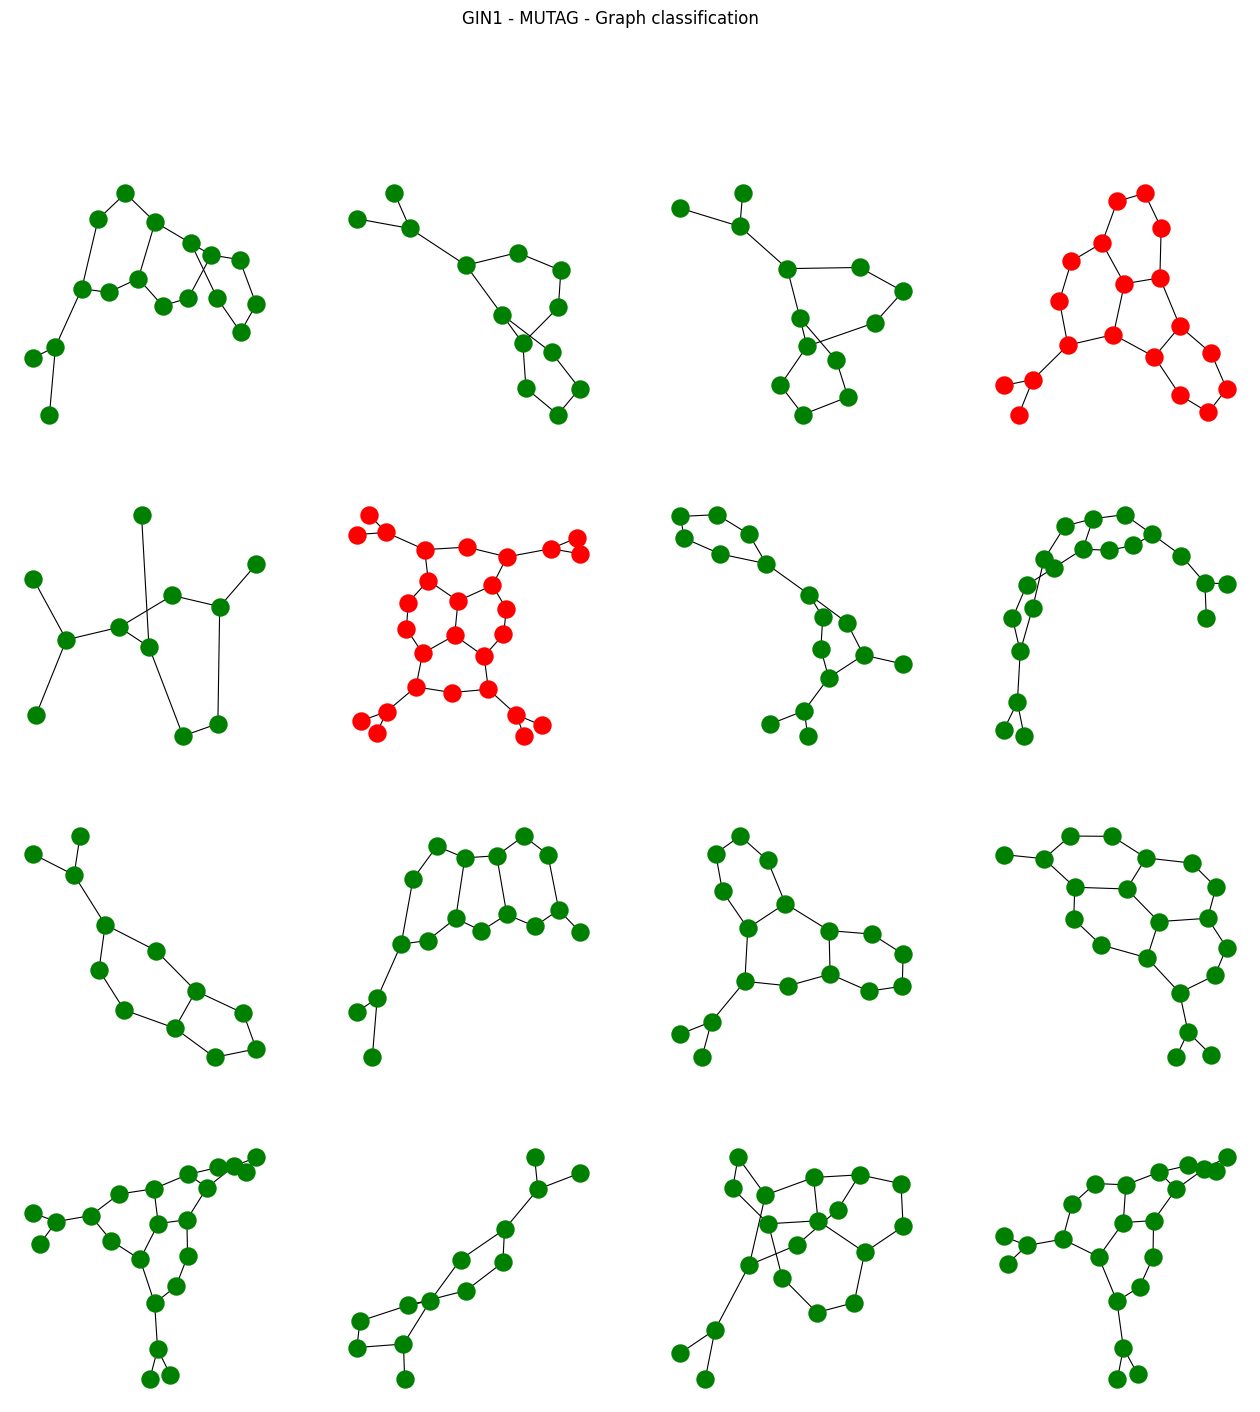

In [56]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN1 - MUTAG - Graph classification')

for i, data in enumerate(GIN1_dataset[188-16:]):
    # Calculate color (green if correct, red otherwise)
    output = GIN1(data.x, data.edge_index, data.batch)
    color = "green" if output.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(GIN1_dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

#### Visualizing the results of the PROTEINS model

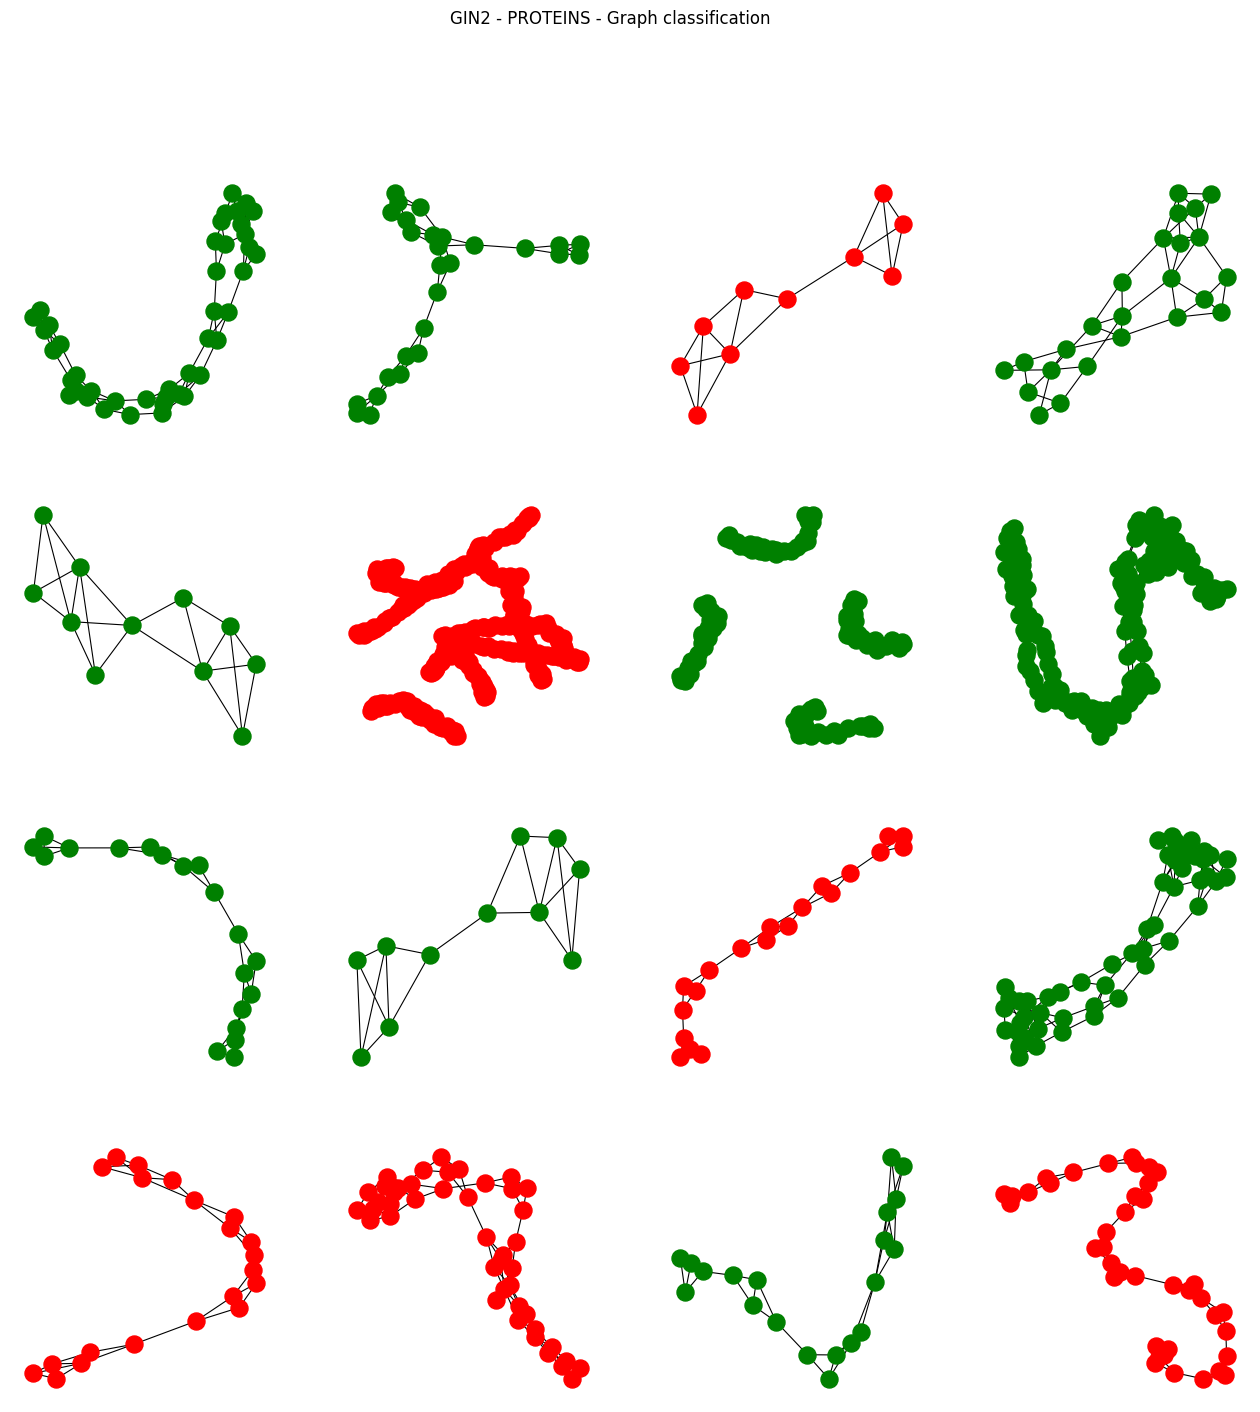

In [57]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN2 - PROTEINS - Graph classification')

for i, data in enumerate(GIN2_dataset[1113-16:]):
    # Calculate color (green if correct, red otherwise)
    output = GIN2(data.x, data.edge_index, data.batch)
    color = "green" if output.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(GIN2_dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )

#### Visualizing the results of the NCTI1 model

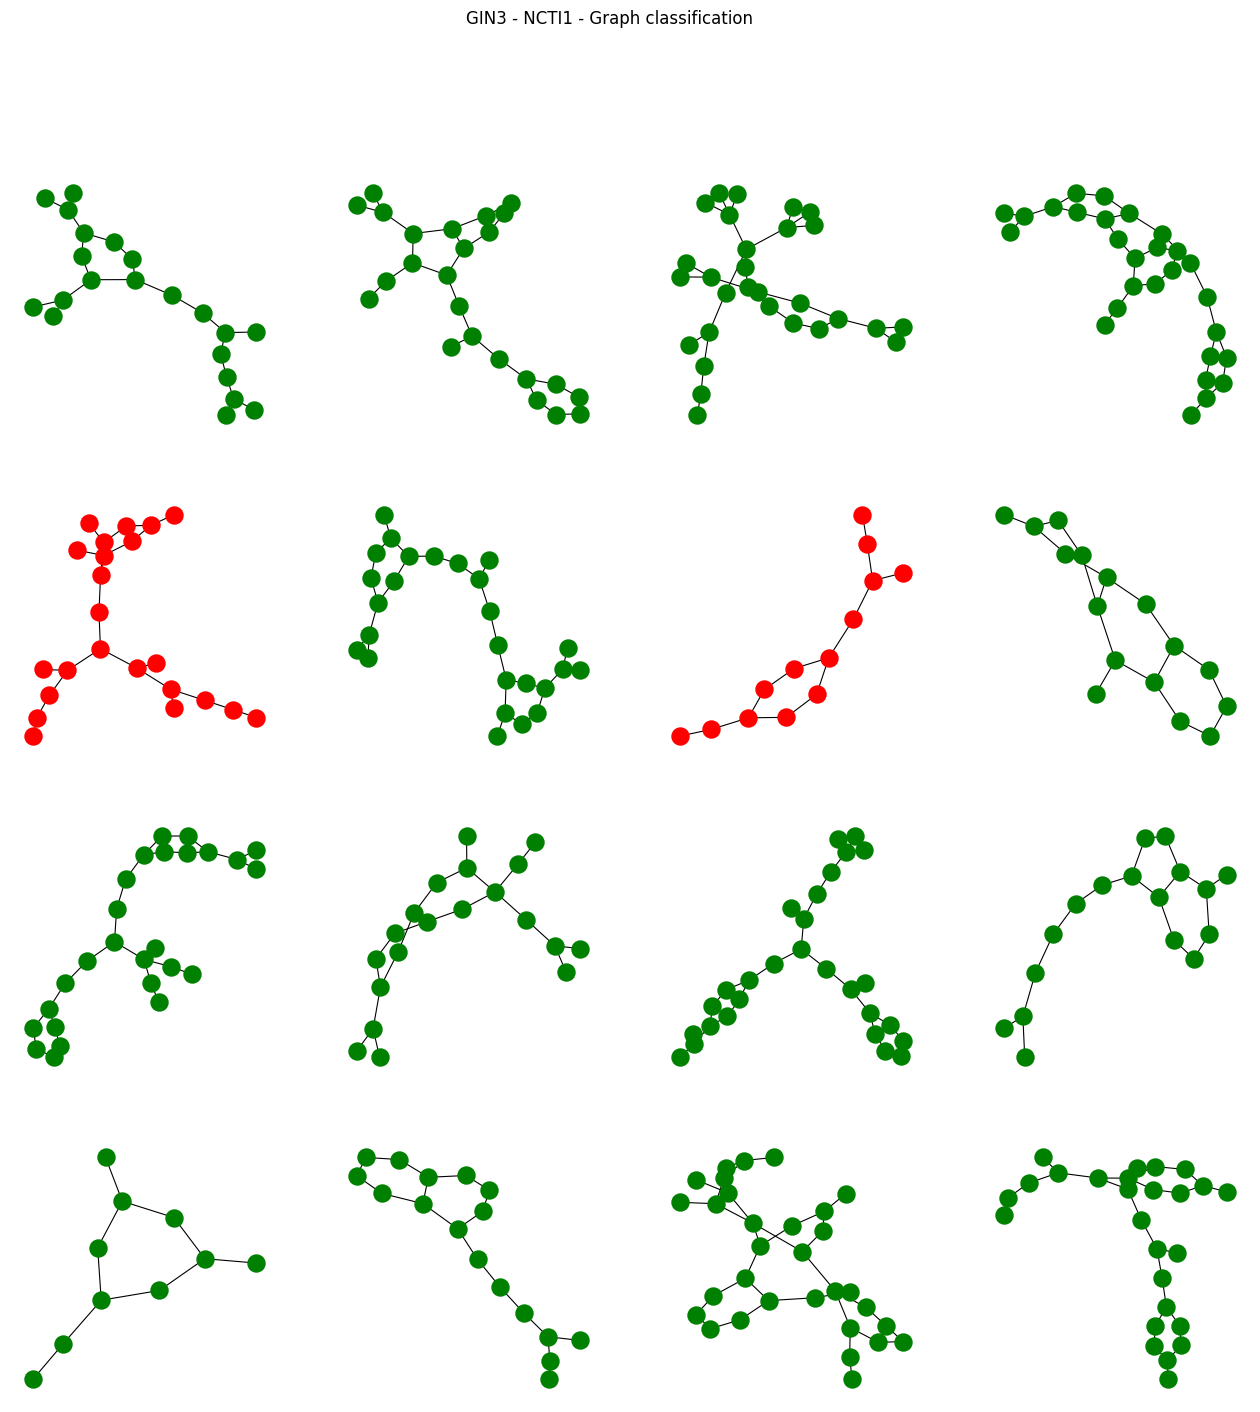

In [58]:
fig, ax = plt.subplots(4, 4, figsize=(16,16))
fig.suptitle('GIN3 - NCTI1 - Graph classification')

for i, data in enumerate(GIN3_dataset[4110-16:]):
    # Calculate color (green if correct, red otherwise)
    output = GIN3(data.x, data.edge_index, data.batch)
    color = "green" if output.argmax(dim=1) == data.y else "red"

    # Plot graph
    ix = np.unravel_index(i, ax.shape)
    ax[ix].axis('off')
    G = to_networkx(GIN3_dataset[i], to_undirected=True)
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=150,
                    node_color=color,
                    width=0.8,
                    ax=ax[ix]
                    )